In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.pulse.library import Waveform
from qiskit.tools.monitor import job_monitor

from scipy.optimize import curve_fit

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split


In [2]:
# Out-of-class helpers
def closest_multiple(N, base : int = 16):
    """
    Return the closest multiple of 'base' to 'N'
    """
    return base * round( N / base )

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped



class QuantumCircuit3:
    """Create a new circuit for a three-level system."""

    def __init__(self, backend):
        # Select quantum and clasical memory slots
        self.qubit = 0
        self.mem_slot = 0

        # Conversion from SI units
        self.ns = 1.0e-9 # Nanoseconds
        self.us = 1.0e-6 # Microseconds
        self.MHz = 1.0e6 # Megahertz
        self.GHz = 1.0e9 # Gigahertz

        # Backend
        self.backend = backend
        self.backend_props    = self.backend.properties()
        self.backend_config   = self.backend.configuration()
        self.backend_defaults = self.backend.defaults()

        # Drive pulse parameters
        self.drive_sigma_s = 75 * self.ns           # Width (duration) of gaussian pulses in microseconds # TODO use 80 ns (0.080 us)
        self.drive_samples_s = self.drive_sigma_s*8 # Truncate gaussian duration

        self.dt = self.backend_config.dt # Device sampling period
        self.drive_sigma = closest_multiple(self.drive_sigma_s / self.dt, 16)
        self.drive_samples = closest_multiple(self.drive_samples_s / self.dt, 16)

        # Frequencies and amplitudes for pi-pulses
        # 01
        self.qubit_freq_est_01 = self.backend_defaults.qubit_freq_est[self.qubit]
        self.pi_amp_01 = 0.1556930479027419
        # 12
        self.qubit_freq_est_12 = self.qubit_freq_est_01 + self.backend_props.qubit_property(self.qubit)['anharmonicity'][0]
        self.pi_amp_12 = 0.2797548240848574

        # Channels
        self.drive_chan = pulse.DriveChannel(self.qubit)
        self.meas_chan = pulse.MeasureChannel(self.qubit)
        self.acq_chan = pulse.AcquireChannel(self.qubit)

        # Circuit schedule accumulator
        self.list_schedule = []


    def apply_sideband(self, pulse, freq, name=None):
        """
        Apply a modulation for a signal 'pulse' according to a frequency 'freq'
        """
        if name is None:
            name = 'Sideband'
        t = np.linspace(0, self.dt * self.drive_samples, self.drive_samples)
        sine = np.sin(2*np.pi * (freq - self.qubit_freq_est_01) * t)

        sideband_pulse = Waveform(np.real(pulse.samples) * sine, name)
        return sideband_pulse

    def sx_01(self):
        """
        Apply a pi/2 pulse on levels 01
        """
        pi_half_pulse_01 = pulse_lib.gaussian(duration=self.drive_samples,
                                         amp=self.pi_amp_01/2,
                                         sigma=self.drive_sigma,
                                         name='sx_01')
        self.list_schedule.append(pulse.Play(pi_half_pulse_01, self.drive_chan))

    def sx_12(self):
        """
        Apply a pi/2 pulse on levels 12
        """
        pi_half_pulse_12 = pulse_lib.gaussian(duration=self.drive_samples,
                                              amp=self.pi_amp_12/2,
                                              sigma=self.drive_sigma,
                                              name='sx_12')
        # make sure this pulse is sidebanded
        pi_half_pulse_12 = self.apply_sideband(pi_half_pulse_12,
                                               self.qubit_freq_est_12,
                                               name='sx_12')
        self.list_schedule.append(pulse.Play(pi_half_pulse_12, self.drive_chan))

    def x_01(self):
        """
        Apply a pi pulse on levels 01
        """
        pi_pulse_01 = pulse_lib.gaussian(duration=self.drive_samples,
                                         amp=self.pi_amp_01,
                                         sigma=self.drive_sigma,
                                         name='x_01')
        self.list_schedule.append(pulse.Play(pi_pulse_01, self.drive_chan))

    def rx_01(self, angle):
        """
        Apply a pi pulse on levels 01
        """
        pi_pulse_01 = pulse_lib.gaussian(duration=self.drive_samples,
                                         amp=self.pi_amp_01*angle/np.pi,
                                         sigma=self.drive_sigma,
                                         name='x_01')
        self.list_schedule.append(pulse.Play(pi_pulse_01, self.drive_chan))


    def y_01(self):
        """
        Apply a y gate on levels 01
        """
        phase_pi = pulse.ShiftPhase(np.pi, self.drive_chan)
        self.list_schedule.append(phase_pi)
        y_01 = pulse_lib.gaussian(duration=self.drive_samples,
                                         amp=self.pi_amp_01,
                                         sigma=self.drive_sigma,
                                         name='y_01')
        pulse_y_01 = pulse.Play(y_01, self.drive_chan)
        self.list_schedule.append(pulse_y_01)


    def x_12(self):
        """
        Apply a pi pulse on levels 12
        """
        pi_pulse_12 = pulse_lib.gaussian(duration=self.drive_samples,
                                         amp=self.pi_amp_12,
                                         sigma=self.drive_sigma,
                                         name='x_12')
        # make sure this pulse is sidebanded
        pi_pulse_12 = self.apply_sideband(pi_pulse_12, self.qubit_freq_est_12,
                                          name="x_12")
        self.list_schedule.append(pulse.Play(pi_pulse_12, self.drive_chan))


    def y_12(self):
        """
        Apply a pi pulse on levels 12
        """
        phase_pi = pulse.ShiftPhase(np.pi, self.drive_chan)
        self.list_schedule.append(phase_pi)
        pi_pulse_12 = pulse_lib.gaussian(duration=self.drive_samples,
                                         amp=self.pi_amp_12,
                                         sigma=self.drive_sigma,
                                         name='y_12')
        # make sure this pulse is sidebanded
        pi_pulse_12 = self.apply_sideband(pi_pulse_12, self.qubit_freq_est_12,
                                          name="y_12")
        self.list_schedule.append(pulse.Play(pi_pulse_12, self.drive_chan))


    def rz(self, phase):
        self.list_schedule.append(pulse.ShiftPhase(phase, self.drive_chan))


    def calibrate_freq_01(self, freqs=None):

        f0 = self.qubit_freq_est_01
        if freqs is None:
            freqs = f0 + np.linspace(-20*self.MHz, 20*self.MHz, 75)

        meas_idx = [self.qubit in group
                        for group in self.backend_config.meas_map].index(True)

        measure_pulse = self.backend_defaults.instruction_schedule_map.get(
            'measure',
            qubits = self.backend_config.meas_map[meas_idx],
            )

        gaussian_pulse = pulse_lib.gaussian(duration=self.drive_samples,
                                            sigma=self.drive_sigma,
                                            amp=0.1)

        # Define schedule
        schedule = pulse.Schedule()
        schedule |= pulse.Play(gaussian_pulse, self.drive_chan)
        schedule |= measure_pulse << schedule.duration

        job = self.backend.run(schedule,
                               meas_level=1,
                               meas_return='avg',
                               shots=1024,
                               schedule_los=[{self.drive_chan: freq} for freq in freqs])

        # Make notice about the on-going job
        print("Calibrating qubit_freq_est_01...")
        job_monitor(job)

        results = job.result(timeout=120)
        results_data = [results.get_memory(i)[self.qubit] for i in range(len(results.results))]

        # Fit Lorentzian response
        fun = lambda x, qf, a, b, c: a * b / ((x-qf)**2 + b**2 ) + c
        ydata = np.real(results_data)
        ydata /= ydata.max()-ydata.min() # Normalize data height
        b = (freqs.max()-freqs.min())/10 # Half-width
        fit_params, *_ = curve_fit(fun, freqs, ydata, [f0, b, b, ydata.mean()])

        # Update frequency estimate
        self.qubit_freq_est_01 = fit_params[0]

        print(f'qubit_freq_est_01 updated from {f0/self.GHz}GHz to {fit_params[0]/self.GHz}GHz.')

    def calibrate_pi_amp_01(self, amps=None):

        amp0 = self.pi_amp_01
        if amps is None:
            amps = np.linspace(0, 0.75, 75)

        meas_idx = [self.qubit in group
                        for group in self.backend_config.meas_map].index(True)

        measure_pulse = self.backend_defaults.instruction_schedule_map.get(
            'measure',
            qubits = self.backend_config.meas_map[meas_idx],
            )

        schedules = []
        for amp in amps:
            gaussian_pulse = pulse_lib.gaussian(duration=self.drive_samples,
                                                sigma=self.drive_sigma,
                                                amp=amp)

            # Define schedule
            schedule = pulse.Schedule()
            schedule |= pulse.Play(gaussian_pulse, self.drive_chan)
            schedule |= measure_pulse << schedule.duration

            # Accumulate
            schedules.append(schedule)

        job = self.backend.run(schedules,
                               meas_level=1,
                               meas_return='avg',
                               shots=1024,
                               schedule_los=[{self.drive_chan: self.qubit_freq_est_01}] * len(amps))

        # Make notice about the on-going job
        print("Calibrating pi_amp_01...")
        job_monitor(job)

        results = job.result(timeout=120)
        results_data = [results.get_memory(i)[self.qubit] for i in range(len(results.results))]

        # Fit response
        fun = lambda x, period, a, b, c: a * np.cos( 2*np.pi*x/period - b ) + c
        ydata = np.real(results_data)
        # Ansatz
        period = amps[-1]/2
        a = ydata.max()-ydata.min()
        b = 0.0
        c = ydata.mean()
        fit_params, *_ = curve_fit(fun, amps, ydata, [period, a, b, c])

        # Update amplitude estimate
        self.pi_amp_01 = abs(fit_params[0] / 2)

        print(f'pi_amp_01 updated from {amp0} to {self.pi_amp_01}.')

    def calibrate_freq_12(self, freqs=None):

        f0 = self.qubit_freq_est_12
        if freqs is None:
            freqs = f0 + np.linspace(-20*self.MHz, 20*self.MHz, 75)

        meas_idx = [self.qubit in group
                        for group in self.backend_config.meas_map].index(True)

        measure_pulse = self.backend_defaults.instruction_schedule_map.get(
            'measure',
            qubits = self.backend_config.meas_map[meas_idx],
            )

        gaussian_pulse = pulse_lib.gaussian(duration=self.drive_samples,
                                            sigma=self.drive_sigma,
                                            amp=0.3)

        pi_pulse_01 = pulse_lib.gaussian(duration=self.drive_samples,
                                         amp=self.pi_amp_01,
                                         sigma=self.drive_sigma,
                                         name='pi_pulse_01')

        schedules = []          # Accumulator
        for freq in freqs:
            sidebanded_pulse = self.apply_sideband(gaussian_pulse, freq)

            schedule = pulse.Schedule()
            schedule |= pulse.Play(pi_pulse_01, self.drive_chan)
            schedule |= pulse.Play(sidebanded_pulse, self.drive_chan) << schedule.duration
            schedule |= measure_pulse << schedule.duration

            schedules.append(schedule)

        job = self.backend.run(schedules,
                               meas_level=1,
                               meas_return='avg',
                               shots=1024,
                               schedule_los=[{self.drive_chan: self.qubit_freq_est_01}] * len(freqs))

        # Make notice about the on-going job
        print("Calibrating qubit_freq_est_12...")
        job_monitor(job)

        results = job.result(timeout=120)
        results_data = [results.get_memory(i)[self.qubit] for i in range(len(results.results))]

        # Fit Lorentzian response
        fun = lambda x, qf, a, b, c: a * b / ((x-qf)**2 + b**2 ) + c
        ydata = np.real(results_data)
        ydata /= ydata.max()-ydata.min() # Normalize data height
        b = (freqs.max()-freqs.min())/10 # Half-width
        fit_params, *_ = curve_fit(fun, freqs, ydata, [f0, b, b, ydata.mean()])

        # Update frequency estimate
        self.qubit_freq_est_12 = fit_params[0]

        print(f'qubit_freq_est_12 updated from {f0/self.GHz}GHz to {fit_params[0]/self.GHz}GHz.')

    def calibrate_pi_amp_12(self, amps=None):

        amp0 = self.pi_amp_12
        if amps is None:
            amps = np.linspace(0, 0.75, 75)

        meas_idx = [self.qubit in group
                        for group in self.backend_config.meas_map].index(True)

        measure_pulse = self.backend_defaults.instruction_schedule_map.get(
            'measure',
            qubits = self.backend_config.meas_map[meas_idx],
            )

        pi_pulse_01 = pulse_lib.gaussian(duration=self.drive_samples,
                                         amp=self.pi_amp_01,
                                         sigma=self.drive_sigma,
                                         name='pi_pulse_01')

        schedules = []
        for amp in amps:
            base_pulse = pulse_lib.gaussian(duration=self.drive_samples,
                                            sigma=self.drive_sigma,
                                            amp=amp)

            sidebanded_pulse = self.apply_sideband(base_pulse, self.qubit_freq_est_12)

            # Define schedule
            schedule = pulse.Schedule()
            schedule |= pulse.Play(pi_pulse_01, self.drive_chan)
            schedule |= pulse.Play(sidebanded_pulse, self.drive_chan) << schedule.duration
            schedule |= measure_pulse << schedule.duration

            # Accumulate
            schedules.append(schedule)

        job = self.backend.run(schedules,
                               meas_level=1,
                               meas_return='avg',
                               shots=1024,
                               schedule_los=[{self.drive_chan: self.qubit_freq_est_01}] * len(amps))

        # Make notice about the on-going job
        print("Calibrating pi_amp_12...")
        job_monitor(job)

        results = job.result(timeout=120)
        results_data = [results.get_memory(i)[self.qubit] for i in range(len(results.results))]

        # Fit response
        fun = lambda x, period, a, b, c: a * np.cos( 2*np.pi*x/period - b ) + c
        ydata = np.real(results_data)
        # Ansatz
        period = amps[-1]/2
        a = ydata.max()-ydata.min()
        b = 0.0
        c = ydata.mean()
        fit_params, *_ = curve_fit(fun, amps, ydata, [period, a, b, c])

        # Update amplitude estimate
        self.pi_amp_12 = abs(fit_params[0] / 2)

        print(f'pi_amp_12 updated from {amp0} to {self.pi_amp_12}.')

    def draw(self, backend=None, *args, **kwargs):
        """
        Join all pulses and draw
        """

        # Default backend
        if backend is None:
            backend = self.backend

        # Join pulses
        schedule = pulse.Schedule()
        for s in self.list_schedule:
            schedule |= s << schedule.duration

        return schedule.draw(backend=backend,
                             *args,
                             **kwargs)
    
    def run(self,
            shots=1024,
            meas_level=2,
            meas_return='avg',
            *args, **kwargs):
        """
        Run circuit on backend
        """

        schedule = pulse.Schedule()
        for s in self.list_schedule:
            schedule |= s << schedule.duration
        
        job = self.backend.run(schedule,
                               shots=shots,
                               meas_level=meas_level,
                               meas_return=meas_return,
                               *args,
                               **kwargs)

        # Make notice about the on-going job
        job_monitor(job)
        results = job.result(timeout=120)
        return results

    def measure(self):
        meas_idx = [self.qubit in group
                        for group in self.backend_config.meas_map].index(True)
        measure_pulse = self.backend_defaults.instruction_schedule_map.get(
            'measure',
            qubits = self.backend_config.meas_map[meas_idx],
            )
        self.list_schedule.append(measure_pulse)
    def measure(self):
        meas_idx = [self.qubit in group
                        for group in self.backend_config.meas_map].index(True)
        measure_pulse = self.backend_defaults.instruction_schedule_map.get(
            'measure',
            qubits = self.backend_config.meas_map[meas_idx],
            )
        self.list_schedule.append(measure_pulse)
        
    def draw(self):
        """
        Join all pulses and draw
        """
        schedule = pulse.Schedule(name='')
        for s in self.list_schedule:
            schedule |= s << schedule.duration
        return schedule.draw(backend=self.backend)
    
    def discriminator012(self, shots=1024):
        
        pi_pulse_01 = pulse_lib.gaussian(duration=self.drive_samples,
                                         amp=self.pi_amp_01,
                                         sigma=self.drive_sigma,
                                         name='x_01')
    
        pi_pulse_12 = pulse_lib.gaussian(duration=self.drive_samples,
                                         amp=self.pi_amp_12,
                                         sigma=self.drive_sigma,
                                         name='x_12')
        # make sure this pulse is sidebanded
        pi_pulse_12 = self.apply_sideband(pi_pulse_12, self.qubit_freq_est_12,
                                          name="x_12")
        
        meas_idx = [self.qubit in group
                        for group in self.backend_config.meas_map].index(True)

        measure_pulse = self.backend_defaults.instruction_schedule_map.get(
            'measure',
            qubits = self.backend_config.meas_map[meas_idx],
            )

        # Create the three schedules

        # Ground state schedule
        zero_schedule = pulse.Schedule(name="zero schedule")
        zero_schedule |= measure_pulse

        # Excited state schedule
        one_schedule = pulse.Schedule(name="one schedule")
        one_schedule |= pulse.Play(pi_pulse_01, self.drive_chan)
        one_schedule |= measure_pulse << one_schedule.duration

        # Excited state schedule
        two_schedule = pulse.Schedule(name="two schedule")
        two_schedule |= pulse.Play(pi_pulse_01, self.drive_chan)
        two_schedule |= pulse.Play(pi_pulse_12, self.drive_chan) << two_schedule.duration
        two_schedule |= measure_pulse << two_schedule.duration
        
        IQ_012_job = self.backend.run([zero_schedule, one_schedule, two_schedule],
                           meas_level=1,
                           meas_return='single',
                           shots=shots,
                           schedule_los=[{self.drive_chan: self.qubit_freq_est_01}] * 3)

        job_monitor(IQ_012_job)
        
        # Get job data (single); split for zero, one and two

        job_results = IQ_012_job.result(timeout=120)
        
        IQ_012_data = []
        for i in range(len(job_results.results)):
            IQ_012_data.append(job_results.get_memory(i)[:, self.qubit])  
        
        zero_data = IQ_012_data[0]
        one_data = IQ_012_data[1]
        two_data = IQ_012_data[2]
        
        # Create IQ vector (split real, imag parts)
        zero_data_reshaped = reshape_complex_vec(zero_data)
        one_data_reshaped = reshape_complex_vec(one_data)  
        two_data_reshaped = reshape_complex_vec(two_data)  

        IQ_012_data_reshaped = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
        
        return IQ_012_data_reshaped

In [3]:
# Load IMB Quantum credentials

from qiskit import IBMQ
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
# Choose device
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

qc = QuantumCircuit3(backend)

# Test calibrations

In [5]:
qc.calibrate_freq_01()


Calibrating qubit_freq_est_01...
Job Status: job has successfully run
qubit_freq_est_01 updated from 4.97158666934091GHz to 4.971589254471257GHz.


In [6]:
qc.calibrate_pi_amp_01()


Calibrating pi_amp_01...
Job Status: job has successfully run
pi_amp_01 updated from 0.1556930479027419 to 0.15547377789714595.


In [7]:
qc.calibrate_freq_12()


Calibrating qubit_freq_est_12...
Job Status: job has successfully run
qubit_freq_est_12 updated from 4.6243937378580835GHz to 4.623395797181759GHz.


In [8]:
qc.calibrate_pi_amp_12()

Calibrating pi_amp_12...
Job Status: job has successfully run
pi_amp_12 updated from 0.2797548240848574 to 0.28170320595937753.


In [9]:
IQ_012_data_reshaped = qc.discriminator012()

Job Status: job has successfully run


In [10]:
def LDA_dis(IQ_012_data, points, shots=1024, acc=False):
        
        # construct vector w/ 0's, 1's and 2's (for testing)
        state_012 = np.zeros(shots) # shots gives number of experiments
        state_012 = np.concatenate((state_012, np.ones(shots)))
        state_012 = np.concatenate((state_012, 2*np.ones(shots)))
        
        # Shuffle and split data into training and test sets
        IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)
        
        # Set up the LDA
        LDA_012 = LinearDiscriminantAnalysis()
        LDA_012.fit(IQ_012_train, state_012_train)
        
        if acc==True:
            score_012 = LDA_012.score(IQ_012_test, state_012_test)
            print(score_012)
        
        counts = LDA_012.predict(points)
        
        return counts

In [11]:
xd = LDA_dis(IQ_012_data_reshaped, IQ_012_data_reshaped, acc=True)

0.8541666666666666


In [12]:
xd0 = xd[0:1023]
xd1 = xd[1024:2047]
xd2 = xd[2048:-1]

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([985.,   0.,   0.,   0.,   0.,  36.,   0.,   0.,   0.,   2.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

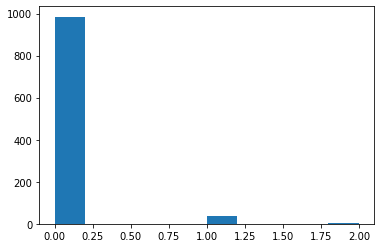

In [14]:
plt.hist(xd0)

(array([ 63.,   0.,   0.,   0.,   0., 823.,   0.,   0.,   0., 137.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

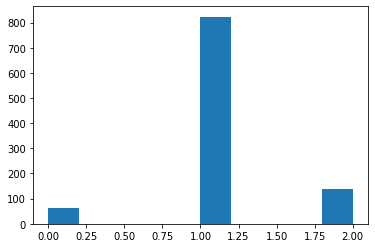

In [15]:
plt.hist(xd1)

(array([ 28.,   0.,   0.,   0.,   0., 182.,   0.,   0.,   0., 813.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

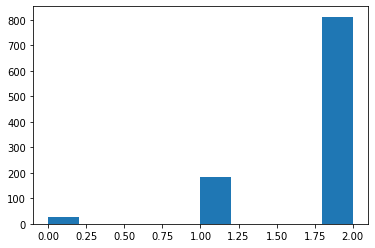

In [16]:
plt.hist(xd2)

(array([1077.,    0.,    0.,    0.,    0., 1042.,    0.,    0.,    0.,
         953.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

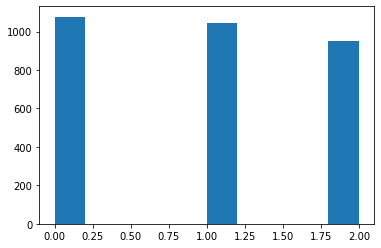

In [17]:
plt.hist(xd)

In [18]:
qc = QuantumCircuit3(backend)
qc.x_01()
qc.x_12()
qc.measure()
qc.draw()

job_results = qc.run(meas_level=1, meas_return='single', shots=1024)

Job Status: job has successfully run


In [19]:
lul = []
for i in range(len(job_results.results)):
    lul.append(job_results.get_memory(i)[:, 0])
    
lul_reshaped = reshape_complex_vec(lul[0])

In [20]:
xdprueba = LDA_dis(IQ_012_data_reshaped, lul_reshaped, acc=True)

0.84765625


(array([ 54.,   0.,   0.,   0.,   0., 272.,   0.,   0.,   0., 698.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

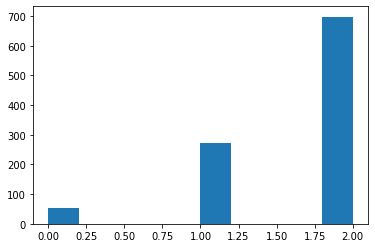

In [27]:
plt.hist(xdprueba)

(array([ 28.,   0.,   0.,   0.,   0., 182.,   0.,   0.,   0., 813.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

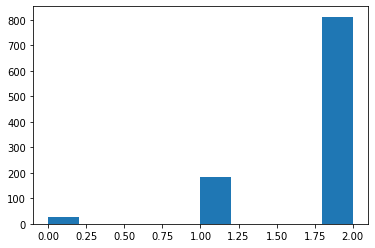

In [22]:
plt.hist(xd2)